In [23]:
import numpy as np
import matplotlib.pyplot as plt

import operator
from itertools import product

from sklearn import datasets
from sklearn.metrics import (
    auc,
    roc_curve)
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.pipeline import _name_estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator,ClassifierMixin,clone

%matplotlib inline

In [3]:
class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers=classifiers
        self.named_classifiers={
            key:value for key,
            value in _name_estimators(classifiers)
        }
        self.vote=vote
        self.weights=weights

    def fit(self,X,y):
        if self.vote not in ('probability','classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'" f" or 'classlabel'" f"; got (vote={self.vote})")
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f"Number of classifiers and weights must be equal;" f"got {len(self.classifiers)} classifiers and {len(self.weights)} weights")
        
        self.labelenc_=LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_=self.labelenc_.classes_
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf=clone(clf).fit(X,self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)

        return self
    
    def predict(self,X):
        if self.vote=='probability':
            maj_vote=np.argmax(self.predict_proba(X),axis=1)
        else:
            predictions=np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote=np.apply_along_axis(
                lambda x:np.argmax(np.bincount(x,weights=self.weights)),
                axis=1,arr=predictions)
            
        maj_vote=self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        probas=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba=np.average(probas,axis=0,weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out=self.named_classifiers.copy()
            for name,step in self.named_classifiers.items():
                for key,value in step.get_params(deep=True).items():
                    out[f'{name}__{key}']=value

        return out            

In [4]:
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]],iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)

In [6]:
clf1=LogisticRegression(penalty='l2',C=0.001,solver='lbfgs',random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

pipe1=Pipeline([['sc',StandardScaler()],
               ['clf',clf1]])
pipe3=Pipeline([['sc',StandardScaler()],
                ['clf',clf3]])
clf_labels=['Logistic Regression','Decision Tree','KNN']
print('10-fold cross validation:\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores=cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc')
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [7]:
mv_clf=MajorityVoteClassifier(
    classifiers=[pipe1,clf2,pipe3])

clf_labels+=['Majority voting']
all_clf=[pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores=cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc')
    print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

Accuracy: 0.92 (+/- 0.15) [Logistic Regression]
Accuracy: 0.87 (+/- 0.18) [Decision Tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


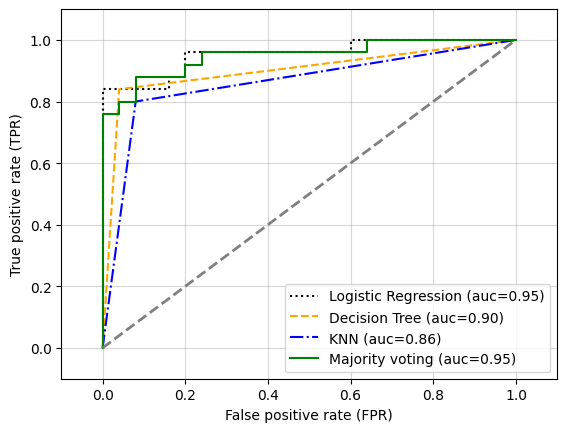

In [15]:
colors=['black','orange','blue','green']
linestyles=[':','--','-.','-']
for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc=auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,
            color=clr,
            linestyle=ls,
            label=f"{label} (auc={roc_auc:.2f})")
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

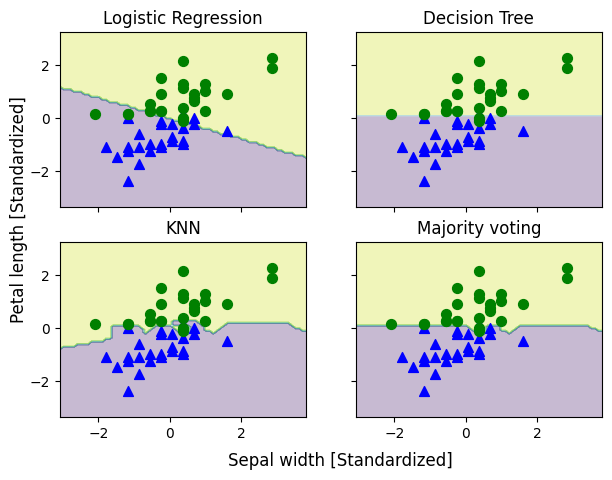

In [21]:
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_min=X_train_std[:,0].min()-1
X_max=X_train_std[:,0].max()+1
y_min=X_train_std[:,1].min()-1
y_max=X_train_std[:,1].max()+1

xx,yy=np.meshgrid(np.arange(X_min,X_max,0.1),
                  np.arange(y_min,y_max,0.1))

f,axarr=plt.subplots(nrows=2,ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7,5))

for idx,clf, tt in zip(product([0,1],[0,1]),
                       all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                   X_train_std[y_train==0,1],
                                   c='blue',
                                   marker='^',
                                   s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                   X_train_std[y_train==1,1],
                                   c='green',
                                   marker='o',
                                   s=50)
    axarr[idx[0],idx[1]].set_title(tt)

plt.text(-3.5,-5.,
         s='Sepal width [Standardized]',
         ha='center',va='center',
         fontsize=12)
plt.text(-12.5,4.5,
         s='Petal length [Standardized]',
         ha='center',va='center',
         fontsize=12,rotation=90)
plt.show()

In [22]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [24]:
params={'decisiontreeclassifier__max_depth':[1,2],
        'pipeline-1__clf__C':[0.001,0.1,100.0]}
grid=GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [25]:
for r,_ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score=grid.cv_results_['mean_test_score'][r]
    std_dev=grid.cv_results_['std_test_score'][r]
    params=grid.cv_results_['params'][r]
    print(f"{mean_score:.3f} +/- {std_dev:.2f} {params}")
    

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [26]:
print(f'ROC AUC : {grid.best_score_:.2f}')

ROC AUC : 0.98
